In [2]:
import sys,mujoco,time,os,json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\helper")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\mujoco_usage")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\gpt_usage")
sys.path.append(r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\package\detection_module")

from mujoco_parser import *
from utility import *
from transformation import *

#sys.path.append('../package/helper/')
#sys.path.append('../package/mujoco_usage/')
#sys.path.append('../package/gpt_usage/')
#sys.path.append('../package/detection_module/')
from mujoco_parser import *
from utility import *
from transformation import *
from gpt_helper import *
from owlv2 import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

c:\Users\ptfc0\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Ready.


In [1]:
import mujoco as mj
from mujoco.glfw import glfw
import OpenGL.GL as gl
from PIL import Image
import numpy as np
import sim_utils
import Functions as F

class MujocoEnv:
    def __init__(self, xml_path, simend=300):
        self.xml_path = xml_path
        self.simend = simend

        # Load model & data
        self.model = mj.MjModel.from_xml_path(xml_path)
        self.data = mj.MjData(self.model)

        # Identify relevant sites and bodies
        self.ee_site_name = "grip_site"
        self.target_body_name = "obj_box_06"
        self.ee_site_id = self.model.site(self.ee_site_name).id
        self.target_body_id = self.model.body(self.target_body_name).id

        # Initialize GLFW
        if not glfw.init():
            raise Exception("Failed to initialize GLFW")

        self.window = glfw.create_window(1200, 900, "Mujoco Env", None, None)
        if not self.window:
            glfw.terminate()
            raise Exception("Failed to create GLFW window")

        glfw.make_context_current(self.window)
        glfw.swap_interval(1)

        # Set callbacks
        glfw.set_key_callback(self.window, sim_utils.keyboard(self.model, self.data))
        glfw.set_mouse_button_callback(self.window, sim_utils.mouse_button())
        glfw.set_cursor_pos_callback(self.window, sim_utils.mouse_move(self.model, None, None))  # scene and cam set later
        glfw.set_scroll_callback(self.window, sim_utils.scroll(self.model, None, None))          # scene and cam set later

        # Mujoco visualization objects
        self.cam = mj.MjvCamera()
        self.opt = mj.MjvOption()
        mj.mjv_defaultCamera(self.cam)
        mj.mjv_defaultOption(self.opt)
        self.scene = mj.MjvScene(self.model, maxgeom=10000)
        self.context = mj.MjrContext(self.model, mj.mjtFontScale.mjFONTSCALE_150.value)

        # Store scene and cam for mouse callback update
        glfw.set_cursor_pos_callback(self.window, sim_utils.mouse_move(self.model, self.scene, self.cam))
        glfw.set_scroll_callback(self.window, sim_utils.scroll(self.model, self.scene, self.cam))

        # Camera initial setup
        self.cam.azimuth = 89.608063
        self.cam.elevation = -1.588379
        self.cam.distance = 2.5
        self.cam.lookat = np.array([0.0, 0.0, 2.0])

        # Control callback setup
        mj.set_mjcb_control(self.controller)

        self.captured = False
        self.rgb_img = None
        self.xyz_img_world = None
        self.saved_capture = False  # New flag to save only once

    def controller(self, model, data):
        # Your IK controller function here...
        nv = model.nv
        ee_pos = data.site_xpos[self.ee_site_id].copy()
        R_ee = data.site_xmat[self.ee_site_id].reshape(3, 3)

        box_pos = data.xpos[self.target_body_id].copy()
        target_pos = box_pos + np.array([0.0, 0.0, 0.10])  # 10 cm above box
        R_box = data.xmat[self.target_body_id].reshape(3, 3)

        R_box_rot = R_box @ F.RotX(np.pi / 2) @ F.RotY(-1 * np.pi / 2)

        pos_err = target_pos - ee_pos

        R_err = 0.5 * (np.cross(R_ee[:, 0], R_box_rot[:, 0]) +
                       np.cross(R_ee[:, 1], R_box_rot[:, 1]) +
                       np.cross(R_ee[:, 2], R_box_rot[:, 2]))

        error = np.hstack((pos_err, R_err))  # 6x1

        Jp = np.zeros((3, nv))
        Jr = np.zeros((3, nv))
        mj.mj_jacSite(model, data, Jp, Jr, self.ee_site_id)
        J_full = np.vstack((Jp, Jr))  # 6 x nv

        lam0 = 1e-3
        lam_scale = 1e-2
        lam = lam0 + lam_scale * np.linalg.norm(pos_err)
        A = J_full @ J_full.T + lam * np.eye(6)
        try:
            dq = J_full.T @ np.linalg.solve(A, error)
        except np.linalg.LinAlgError:
            dq = J_full.T @ np.linalg.pinv(A) @ error

        max_dq_norm = 0.2
        dq_norm = np.linalg.norm(dq)
        if dq_norm > max_dq_norm:
            dq *= max_dq_norm / dq_norm
        alpha = 0.25
        dq_step = alpha * dq

        q = data.qpos[:nv].copy()
        q_des = q + dq_step

        Kp = 200
        Kd = 10.0
        q_err = q_des - q
        qd = data.qvel[:nv].copy()
        f = data.qfrc_bias.copy()
        tau = (Kp * q_err) + (Kd * (-qd)) + f

        torque_limit = 200.0
        tau = np.clip(tau, -torque_limit, torque_limit)
        data.qfrc_applied[:] = tau
    
    def is_viewer_alive(self):
        return not glfw.window_should_close(self.window)

    def reset(self):
        mj.mj_resetData(self.model,self.data)
        self.data.time=0
        self.captured-False
        print("Environment Reset")

    def plot_text(self, p, label, size=10, rgba=(1,1,1,1)):
        marker = mj.MjvMarker()
        marker.type = mj.mjtGeom.mjGEOM_TEXT
        marker.pos = p
        marker.text = label.encode('utf-8')
        marker.size = size
        marker.rgba = rgba
    # Store the marker to be added each frame
        if not hasattr(self, '_text_markers'):
            self._text_markers = []
        self._text_markers.append(marker)

    def init_viewer(self,
                    transparent=False,
                    azimuth=89.608063,
                    distance=3,
                    elevation=-11.588379,
                    lookat=[0,0,2]):
        self.cam.azimuth=azimuth
        self.cam.elevation=elevation
        self.cam.distance=distance
        self.cam.lookat[:]=lookat

    def set_state(self,qpos=None,qvel=None):
        if qpos is not None:
            self.data.qpos[:len(qpos)]=qpos
        if qvel is not None:
            self.data.qvel[:len(qvel)]=qvel
            mj.mj_forward(self.model,self.data)

    def grab_mujoco_rgb_image(self, viewport_width, viewport_height):
        gl.glPixelStorei(gl.GL_PACK_ALIGNMENT, 1)
        pixels = gl.glReadPixels(0, 0, viewport_width, viewport_height, gl.GL_RGBA, gl.GL_UNSIGNED_BYTE)
        image = np.frombuffer(pixels, dtype=np.uint8).reshape(viewport_height, viewport_width, 4)
        image = np.flip(image, axis=0)  # Flip vertically
        return Image.fromarray(image)

    def depth_to_xyz(self, depth_img, cam, viewport_width, viewport_height):
        depth = depth_img.astype(np.float32) / (2**24 - 1)
        near = 0.01
        far = 1000.0
        z_linear = near * far / (far - (far - near) * depth)

        fovy_rad = np.deg2rad(45)
        fy = viewport_height / (2 * np.tan(fovy_rad / 2))
        fx = fy
        cx = viewport_width / 2
        cy = viewport_height / 2

        x = np.arange(viewport_width)
        y = np.arange(viewport_height)
        xv, yv = np.meshgrid(x, y)

        X = (xv - cx) * z_linear / fx
        Y = (yv - cy) * z_linear / fy
        Z = z_linear

        xyz = np.stack([X, Y, Z], axis=-1)
        return xyz
    
    def cam_spherical_to_pose(self, cam):
        az = np.deg2rad(cam.azimuth)
        el = np.deg2rad(cam.elevation)
        dist = cam.distance
        lookat = cam.lookat

        x = dist * np.cos(el) * np.sin(az)
        y = dist * np.cos(el) * np.cos(az)
        z = dist * np.sin(el)
        cam_pos = lookat + np.array([x, y, z])

        z_axis = lookat - cam_pos
        z_axis /= np.linalg.norm(z_axis)

        up = np.array([0, 0, 1])
        x_axis = np.cross(up, z_axis)
        x_axis /= np.linalg.norm(x_axis)

        y_axis = np.cross(z_axis, x_axis)

        cam_mat = np.stack([x_axis, y_axis, z_axis], axis=1)
        return cam_pos, cam_mat

    def run(self):
        while not glfw.window_should_close(self.window):
            simstart = self.data.time

            while (self.data.time - simstart < 1.0 / 60.0):
                mj.mj_step(self.model, self.data)

            if self.data.time >= self.simend:
                break

            viewport_width, viewport_height = glfw.get_framebuffer_size(self.window)
            viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

            mj.mjv_updateScene(self.model, self.data, self.opt, None, self.cam,
                               mj.mjtCatBit.mjCAT_ALL.value, self.scene)
            mj.mjr_render(viewport, self.scene, self.context)

            if not self.captured:
                # Grab RGB image
                img = self.grab_mujoco_rgb_image(viewport_width, viewport_height)
                img.save("camera_capture.png")
                print("Saved camera_capture.png")
                self.rgb_img = np.array(img)

                # Read depth buffer
                depth_buffer = gl.glReadPixels(0, 0, viewport_width, viewport_height,
                                               gl.GL_DEPTH_COMPONENT, gl.GL_FLOAT)
                depth_img = np.frombuffer(depth_buffer, dtype=np.float32).reshape(viewport_height, viewport_width)
                depth_img = np.flip(depth_img, axis=0)  # flip vertically

                # Convert depth to xyz in camera frame
                xyz_img = self.depth_to_xyz(depth_img, self.cam, viewport_width, viewport_height)

                # Get camera pose from spherical params
                cam_pos, cam_mat = self.cam_spherical_to_pose(self.cam)

                # Transform points from camera frame to world frame
                xyz_flat = xyz_img.reshape(-1, 3).T  # shape (3, N)
                xyz_world_flat = cam_mat @ xyz_flat + cam_pos.reshape(3, 1)
                self.xyz_img_world = xyz_world_flat.T.reshape(viewport_height, viewport_width, 3)
                print("Captured xyz point cloud in world coordinates.")
                self.captured = True

            # Save captured data once after first capture
            if self.captured and not self.saved_capture:
                np.save("xyz_img_world.npy", self.xyz_img_world)
                print("Saved xyz_img_world.npy")
                self.saved_capture = True

            glfw.swap_buffers(self.window)
            glfw.poll_events()

        glfw.terminate()

    def close(self):
        glfw.terminate()

if __name__ == "__main__":
    xml_path = r"C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\franka_panda_w_objs.xml"
    env = MujocoEnv(xml_path)
    env.run()

    # Now you can load the saved data in another script as:
    #
    # import numpy as np
    # xyz_img_world = np.load("xyz_img_world.npy")
    # from PIL import Image
    # rgb_img = np.array(Image.open("camera_capture.png"))


Saved camera_capture.png
Captured xyz point cloud in world coordinates.
Saved xyz_img_world.npy


In [3]:

# Now you can load the saved data in another script a  #
import numpy as np
xyz_img_world = np.load("xyz_img_world.npy")
from PIL import Image
rgb_img = np.array(Image.open("camera_capture.png"))

In [4]:
png_path = r'C:\Users\ptfc0\Downloads\LabratoryPickNPlace-main\LabratoryPickNPlace-main\camera_capture.png'
img = Image.open(png_path)   # PIL Image object
img.show()

In [5]:
# Instantiate GPT4V helper
GPT = GPT4VchatClass(
    gpt_model = "gpt-4o", #"gpt-4-vision-preview",
    role_msg  = "You are a helpful agent with vision capabilities; do not respond to objects not depicted in images.",
    key_path  = r"C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt",
)
print ("Ready.")

key_path:[C:\Users\ptfc0\Downloads\yet-another-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\yet-anot
her-mujoco-tutorial-v3-45e5568a2ffdb6a19a48c5f44167938f01dd15cb\package\gpt_usage\moore_key.txt]

Chat agent using  initialized with the follow role:[You are a helpful agent with vision capabilities; do not 
respond to objects not depicted in images.]

Ready.


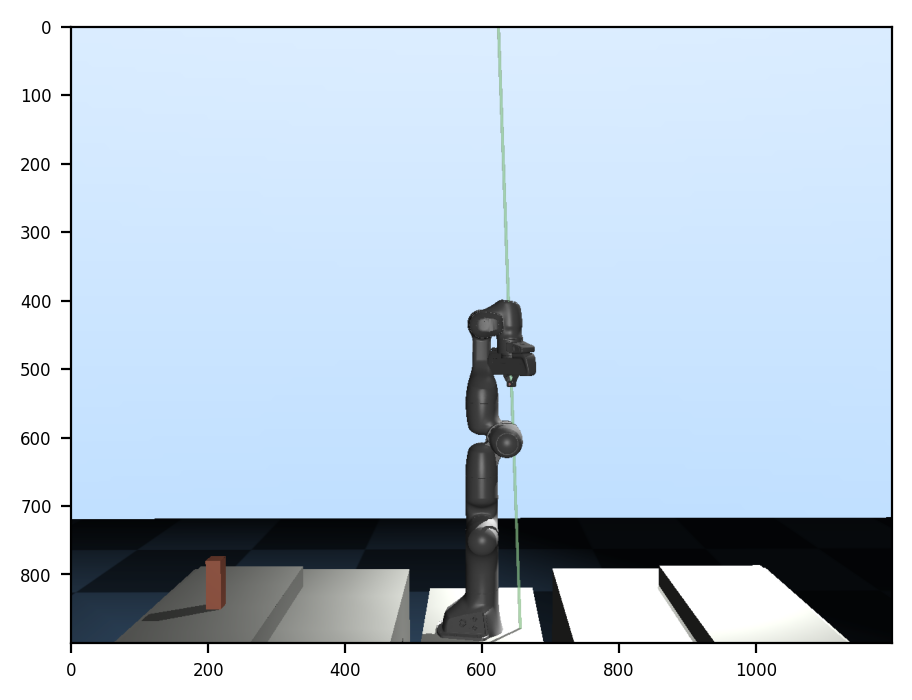

[USER_MSG]

<img1>Describe the image.

[GPT_OUTPUT]

The image shows a robotic arm standing upright on a platform. The arm is composed of several segments and joints, allowing for articulation. It is facing an area with three parallel ramps of different heights. The surface of each ramp seems to be smooth and flat. There is a small brown block on the leftmost ramp. In the background is a light blue sky, and a faint green line extends vertically from the arm, indicating a possible alignment or measurement tool. The overall scene has a digital or simulated appearance.

[USER_MSG]


        Could you list down the object names suitable for detection in a json format? specifically what the robot could pick up the object is smaller than the robot hand. 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        

[GPT_OUTPUT]

```json
{
  "objects": [
    "brown block"
  ]
}
```

Done.


In [6]:
# Plot
plt.figure(figsize=(6,4))
plt.imshow(img)
plt.show()
# Describe the image
GPT.chat(
    user_msg = "<img1>Describe the image.",
    images   = [png_path],
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = False,
    MAX_TOKENS       = 512,
)
# List down the objects in the scene
ret = GPT.chat(
    user_msg = """
        Could you list down the object names suitable for detection in a json format? specifically what the robot could pick up the object is smaller than the robot hand. 
        Below is an example of a json format:
        {
          "objects": [
            "apple fruit",
            "lemon fruit",
            "orange fruit",
            "coke can",
            "kitcat cookie",
          ]
        }
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)
print ("Done.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


object_names:['brown block']


c:\Users\ptfc0\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\models\owlv2\processing_owlv2.py:201: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


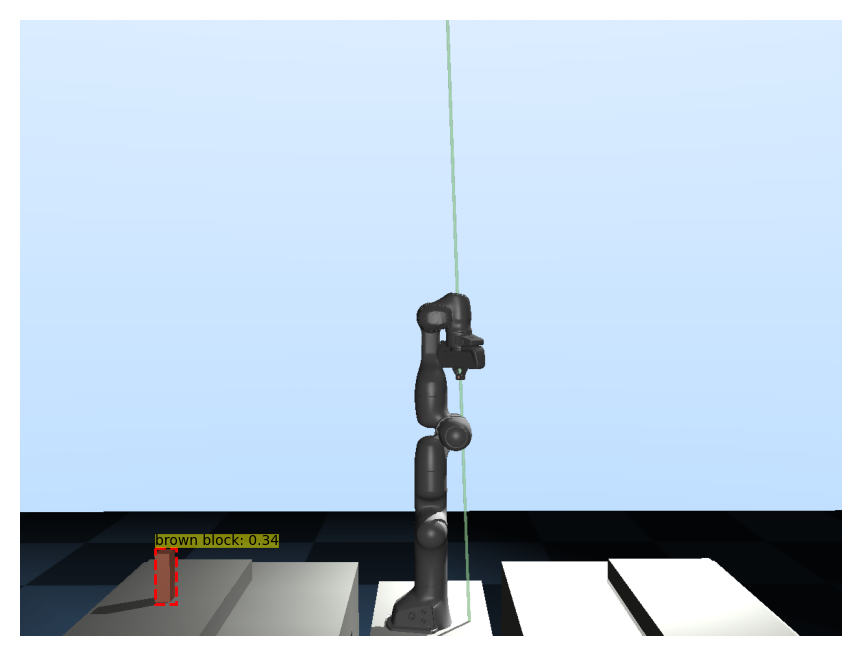

In [7]:
# Parse object names
json_string = ret[ret.find('{'):ret.rfind('}')+1]
data = json.loads(json_string)
object_names = data['objects']
print ("object_names:%s"%(object_names))

# Open-vocab detection
owlvit = Owlv2()
detection_result = owlvit.detect_objects(
    image_path    = png_path,
    object_names  = object_names,
    box_threshold = 0.25,
)

# Plot detection results
plot_detection_result(
    image_path       = png_path,
    detection_result = detection_result,
    figsize          = (6,4),
    fontsize         = 5,
)

In [8]:
# Store current GPT message
gpt_state = GPT.get_state()
print ("GPT state ready.")

GPT state ready.


In [9]:
# Set GPT state
GPT.set_state(state=gpt_state)
ret = GPT.chat(
    user_msg = """
        xyz_centers in the code holds the point centers for each detected object can u tell me what those are?
        """,
    images   = None,
    PRINT_USER_MSG   = True,
    PRINT_GPT_OUTPUT = True,
    RESET_CHAT       = False,
    RETURN_RESPONSE  = True,
    MAX_TOKENS       = 512,
)

[USER_MSG]


        xyz_centers in the code holds the point centers for each detected object can u tell me what those are?
        

[GPT_OUTPUT]

In the context of object detection in 3D environments, `xyz_centers` typically represents the central coordinates of detected objects in a 3D space. Each entry would be a tuple or list containing the X, Y, and Z coordinates.

The coordinates provide the position of the center of each object, helping to locate them relative to the robot. This information is crucial for tasks like picking and placing objects.

Without specific values, a general example of `xyz_centers` might look like this:

```json
{
  "xyz_centers": [
    [1.0, 2.0, 0.5],  // Center for object 1
    [3.5, 1.5, 0.2],  // Center for object 2
    [2.2, 0.8, 0.7]   // Center for object 3
  ]
}
```

Each sub-list or tuple represents the X, Y, and Z coordinates for the center of an object.